In [1424]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
import os
import enchant
from scipy.stats.stats import pearsonr
from scipy.spatial.distance import cdist
from itertools import islice
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import json
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

In [1425]:
import googletrans
from googletrans import Translator
import time
import re
import unicodedata

In [1426]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1427]:
DATA_FOLDER = "data"
data_path = os.path.join(DATA_FOLDER) + "/"

if not DATA_FOLDER in os.listdir():
    os.mkdir(DATA_FOLDER)

# Read csv

In [1428]:
df = pd.read_csv(data_path+'Beer_dataset_v1.csv', index_col=0)

In [1429]:
df.Description = df.Description.fillna('')

In [1430]:
df.shape

(7861, 6)

In [1431]:
df.isna().sum()

Name              0
Style             0
ABV             185
IBU            3289
Rating         2891
Description       0
dtype: int64

In [1432]:
df.head(10)

,Name,Style,ABV,IBU,Rating,Description
0,La Vella Caravana / Black Bitch Caravan of Bitches,Witbier,5.2,29.0,NaN,"Caravan of Bitches\nHoppy Wheat Ale\nEstilo tradicional elaborado con malta pilsner, trigo y avena. Este estilo se caracteriza por las adiciones de cascara de naranja amarga y semillas de cilantro."
1,BlackLab Sour Lady,Berliner Weisse,5.0,NaN,NaN,Sour Lady\nBerliner Weisse with fruit\nUna cerveza ácida con frambuesas.\n---------------\nSour beer with raspberries
2,Blacklab Claudia Passion,American IPA,NaN,NaN,NaN,Claudia Passion\nFruit IPA\nNuestra mejor cerveza con Maracuyá\n--------------\nOur best IPA with passion fruit
3,BlackLab More Sparkle,Brut IPA,7.0,NaN,NaN,More Sparkle\nBrut IPA\nDry and aromatic. Low bitterness.\n-----------\nMuy seca y aromática. Poco amargor.
4,Greyhound Brewers Give ’em Hops,Imperial IPA,8.0,NaN,NaN,Give ’em Hops\nDoble NEIPA
5,Greyhound Brewers Slave of New Hops,American IPA,6.7,50.0,3.76,Slave of New Hops\nIPA
6,Greyhound Brewers Born Of The Hops,American IPA,NaN,NaN,NaN,"Born Of The Hops\nWest Coast IPA\nBorn Of The Hops, una West Coast IPA amarga, herbal, resinosa, como las de antes... Simcoe, Cascade y Columbus para saciar tu dependencia al lúpulo!"
7,Engorile King Hop,Imperial IPA,8.5,204.0,3.82,"King Hop\nImperial IPA\nKing Hop es una cerveza de cuerpo, mucho cuerpo, cómo marca el estilo. Color anaranjado, extremadamente turbia. En nariz es potente, predominante el aroma tropical gracias a su triple Dry Hop de 20,5 gramos/litro y a la combinación de lúpulos de los cuales predomina el ..."
8,Castelló Beer Factory Malaspina Brown Ale,Brown Ale,5.5,22.0,NaN,"Malaspina Brown Ale\nBrown Ale\nCerveza tostada elaborada de manera artesanal a partir de una selección de maltas de cebada, dando como resultado una cerveza de color cobrizo oscuro, con un sabor suave y un amargor equilibrado, presentando un intenso aroma tostado con notas de lúpulo y una espu ..."
9,Castelló Beer Factory / Althaia Fifth Element,Imperial IPA,7.0,NaN,4.20,"Fifth Element\nQuintuple Dry Hopped Doble IPA Cerveza extra producida en casa CBF con la colaboración de Althaia. x5 Dry Hopping con 5 de los lúpulos más potentes del mercado añadidos en 5 adiciones diferentes durante la fermentación: Mosaic, Citra, Nelson Sauvin, Simcoe y Amarillo. Una sop ..."


# Merge to fill breweries

In [1475]:
df_breweries = pd.read_csv(data_path+"dataset_brewery.csv")

In [1476]:
df_breweries.head()

,ABV,Brewery,Description,IBU,Name,Rating,Style,URL
0,4.5 º,Hordago,Hordago Cuélebre\r\nLa mezcla de cebada y trigo junto con lúpulos de aroma cítrico y la piel de naranja amarga hacen que esta cerveza sea fácil de beber y muy refrescante.\r\nIdeal para aplacar la sed o para subir los ánimos.,4.5 º,Hordago Cuélebre,NaN,Witbier,/cervezas/hordago-cuelebre
1,11 º,Fermun Beers,"Malalts de Malta\r\nQuadrupel tipo trapense con cerezas negras cuya producción requiere maltas especiales belgas y azúcar candy. Necesita una buena levadura belga además de guarda. Ofrece notas licorosas, uva pasa, frutos secos y recuerdos a cereza.\r\nEsta ... Ver más se envejece por más de 2 años. Ver menos",11 º,Fermun Beers Malalts de Malta,NaN,Belgian Dark Strong Ale,/cervezas/fermun-beers-malalts-de-malta
2,"starstarstarstar_halfstar_border 3,50",MarinaBrouwerij Het Nest,Het Nest / Marina Full Of Hops Belgian Trippel IPA\nFull Of Hops Trippel,"starstarstarstar_halfstar_border 3,50",Het Nest / Marina Full Of Hops Belgian Trippel IPA,NaN,Belgian Tripel,/cervezas/het-nest---marina-full-of-hops-belgian-trippel-ipa
3,4.7 º,Marbel,Marbel Porter,4.7 º,Marbel Porter,NaN,Porter,/cervezas/marbel-porter
4,NaN,Les Canyes,"Kölsch Fargo de Pepe Cubillo (QuoNos) Casa rural Les Canyes, Primer premio ACCE 2014",NaN,Les Canyes Kölsch Fargo,NaN,Kölsch,/cervezas/les-canyes-kolsch-fargo


In [1435]:
df_breweries.Name.value_counts().head(10)

La Calavera Rossa                          2
Roses de Llobrega Special Bitter           2
Golden Promise Scottish Ale                2
Victoria Sin                               2
Zulogaarden Cojo Manteka                   2
Beertag Blonde Ale                         2
Península La Gorda                         2
Naparbier / Magick Rock Monster Factory    2
Redneck Honky Tonk                         2
Pedraforca Niu Nou                         2
Name: Name, dtype: int64

In [1436]:
df_breweries.Name.nunique()

7906

In [1437]:
# df_breweries = df_breweries[['Name', 'Brewery']]
df_breweries = df_breweries[['Name', 'Brewery', 'Description']]

df_breweries.rename(columns={'Brewery': 'Brewery_full'}, inplace=True)
df_breweries.rename(columns={'Description': 'Description_full'}, inplace=True)

In [1438]:
df_breweries.Name = df_breweries.Name.str.rstrip()
df_breweries.Name = df_breweries.Name.str.lstrip()

In [1439]:
df = df.merge(df_breweries, on='Name', how='left')

In [1440]:
df.Description_full = df.Description_full.fillna('')

In [1441]:
df.sample(5)

,Name,Style,ABV,IBU,Rating,Description,Brewery_full,Description_full
3822,Mad Brewing / Guineu Toma Shock,American IPA,6.5,130.0,NaN,"Mad Brewing / Guineu Toma Shock\r\nTomahawk IPA experience.\r\nTomahawk, Cascade, Citra, Mosaic con Dryhopping de Tomahawk y TNT",Mad BrewingGuineu - Ca l’Arenys,"Mad Brewing / Guineu Toma Shock\r\nTomahawk IPA experience.\r\nTomahawk, Cascade, Citra, Mosaic con Dryhopping de Tomahawk y TNT"
7429,BBF Aigua Specialty Ale,Ale,4.8,20.0,3.35,"Todo es agua o sus combinaciones. El agua es la raíz de toda la vida de nuestro pequeño planeta azul y es el agua la que lo distingue de los demás. Proporcionalmente somos más agua que cualquier otro elemento. En esto nos parecemos al resto de organismos vivos y por tanto, también a la cer ...",Birra 08,"Todo es agua o sus combinaciones. El agua es la raíz de toda la vida de nuestro pequeño planeta azul y es el agua la que lo distingue de los demás. Proporcionalmente somos más agua que cualquier otro elemento. En esto nos parecemos al resto de ... Ver más vivos y por tanto, también a la cerveza. El agua es la raíz de todo y hemos querido utilizar un agua de raíces para hacer una regresión hacia los orígenes. SI el agua es la raíz, nuestra Root’s Water es la evolución. Todo es agua o combinac..."
5885,Spigha Coffee Porter,Robust Porter,6.5,NaN,3.80,"Cerveza elaborada en colaboración con el maestro cervecero norteamericano Daniel Fernández de Beancurdturtle Brewing. Una Robust Porter sometida a un 'drycoffeeing', infusión de granos de café. Uno de los objetivos de esta cerveza es encontrar un parecido al típico café licor de las comar ...",SpighaBeancurdturtle,"Cerveza elaborada en colaboración con el maestro cervecero norteamericano Daniel Fernández de Beancurdturtle Brewing. Una Robust Porter sometida a un drycoffeeing, infusión de granos de café. Uno de los objetivos de esta cerveza es encontrar un ... Ver más al típico café licor de las comarcas de lAlcoià i el Comtat Ver menos"
738,Basqueland Different Folks,Session IPA,4.9,30.0,3.66,Different Folks,Basqueland Brewing Project,Different Folks
7512,Medina Blanca de Castilla,Witbier,4.4,10.0,3.22,"Se trata de una cerveza que en apariencia es fiel al estilo belga (clara y ligeramente turbia), con una espuma muy blanca, pero que cuando nos acercamos a ella nos sorprende con aromas que no son habituales en este estilo; se trata del tomillo y del trigo, que toman un claro protagonismo en det ...",Cervezas Medina,"Se trata de una cerveza que en apariencia es fiel al estilo belga (clara y ligeramente turbia), con una espuma muy blanca, pero que cuando nos acercamos a ella nos sorprende con aromas que no son habituales en este estilo; se trata del tomillo y del ... Ver más que toman un claro protagonismo en detrimento de los más habituales a semilla de cilantro y piel de naranja. Cuando damos un trago resulta una cerveza muy ligera, donde inicialmente notamos el sabor a trigo (pan) y a tomillo, que podr..."


In [1442]:
df.shape

(7879, 8)

In [1443]:
df[['Name', 'Brewery_full']].sample(5)

,Name,Brewery_full
4164,Moli de Rafelet Theresa,NaN
2347,Tibidabo Brewing Barrel Aged 2 - Breckenridge,Tibidabo Brewing
4243,Barcelona Beer Company Sr. Lobo,Barcelona Beer Company
7695,Illa Premium,Cervesa Illa
6343,Baias TX,Baias Garagardotegia


In [1444]:
df.isna().sum()

Name                   0
Style                  0
ABV                  185
IBU                 3298
Rating              2897
Description            0
Brewery_full         385
Description_full       0
dtype: int64

In [1445]:
df_breweries.isna().sum()

Name                 0
Brewery_full         0
Description_full    30
dtype: int64

In [1446]:
df[df.Brewery_full.isna()]

,Name,Style,ABV,IBU,Rating,Description,Brewery_full,Description_full
29,El Pedal Export Stout,Foreign Extra Stout,6.0,NaN,NaN,Export Stout,NaN,
33,Garage Beer Co Scripted Spiel Wipa,American IPA,5.5,NaN,3.88,"Scripted Spiel Wipa\nWest Coast IPA, 5,5% ABV elaborado con lúpulos Simcoe, Amarillo, Ekuanot y Columbus",NaN,
64,A Cova Céltica Fartura,American Pale Ale,5.5,NaN,NaN,"Fartura\nGZ Pale Ale\nAmerican Pale Ale con lúpulos del valle de Órbigo, en León, y lúpulos americanos.\nColor dorado, con una graduación de 5,5 y un toque amargo y seco con toques de melocotón.",NaN,
103,Click&Brew Iler,American Pale Ale,0.0,NaN,NaN,,NaN,
105,Albert The Great Batch #1,Stout,12.0,40.0,3.99,,NaN,
159,Beering Barcelona Fight Ink,American IPA,6.0,60.0,NaN,Fight Ink\nWest Coast IPA\nColaboración con @goontattoo elaborada en Gross.,NaN,
207,CerveZahara La Cachonda,India Pale Ale,6.8,50.0,3.28,"La Cachonda\nCerveza de estilo IPA (Indian Pale Ale) de color dorado media espuma blanquecina , cremosa y con buena persistencia, aromas con notas florales, frutas tropicales especialmente a Mango y con ligeros toques cítricos.",NaN,
252,Ruben’s Schwarz 2,Schwarzbier (Black Beer),4.3,NaN,3.30,"Schwarz 2\nSchwarzbier\nCerveza lager tipo Schwarzbier, cuyo nombre en alemán significa ""Cerveza Negra"". Color oscuro, con espuma beige-canela y cremosa. Suaves aromas a tostado, malta, café.",NaN,
321,Kusfollin En El Nom Del Porc,New England IPA,4.7,NaN,3.68,En El Nom Del Porc\nDDH NEIPA,NaN,
333,Entre Fronteras La Chisparrera,Belgian Blonde Ale,6.0,NaN,3.57,"La Chisparrera\nCerveza de color dorado y espuma blanca, con aromas de cítrico y piel de naranja. De sabor con amargor medio y con notas a malta y notas cítricas. La sensación en boca es agradable y chisposa. Se recomienda beber en vaso tulipa o copa. Marida bien con pollo, salchichas, quesos ...",NaN,


In [1447]:
df_breweries[df_breweries.Name.str.contains('Great Batch')]

,Name,Brewery_full,Description_full


In [1448]:
df[df.Name.str.contains('Pedal Export')]

,Name,Style,ABV,IBU,Rating,Description,Brewery_full,Description_full
29,El Pedal Export Stout,Foreign Extra Stout,6.0,NaN,NaN,Export Stout,NaN,


TO DO:
    - Revisar las cervezas que faltan en el nuevo dataset antes de hacer el cruce

# Merge to fill description (old)

In [1449]:
# descr_df = pd.read_csv('dataset_ramon.csv')

In [1450]:
# descr_df = descr_df[['Name', 'Description']]
# descr_df.rename(columns={'Description': 'Description_full'}, inplace=True)

In [1451]:
# descr_df.Description_full = descr_df.Description_full.str.replace('Ver menos', '')
# descr_df.Description_full = descr_df.Description_full.str.replace('Ver más', '')

In [1452]:
# df.Name.nunique()

In [1453]:
# descr_df.Name.nunique()

In [1454]:
# df = df.merge(descr_df, on='Name', how='left')

In [1455]:
# df.shape

In [1456]:
# df.Description_full = df.Description_full.fillna('')

# Clean Description

In [1457]:
df['Description_full_clean'] = df['Description_full'].apply(lambda x: x.rstrip())
df['Description_full_clean'] = df['Description_full_clean'].map(lambda x: re.sub(r'.{1,50}\n', ' ', x)).str.lower()

In [1458]:
df[['Name', 'Description_full', 'Description_full_clean']].sample(5)

,Name,Description_full,Description_full_clean
4438,Enigma Cervantes 400,"Enigma Cervantes 400\r\nCerveza conmemorativa del IV Centenario de la muerte de Miguel de Cervantes.\r\nEnigma Cervantes 400 - Eniwit. Refrescante con acabado seco y ligeramente ácido, ideal para combatir la sed, con toques placenteros donde se adivinan ... Ver más trigo, plátano y una chispa sorprendente de cilantro.\r\nUn sabor sutil y balanceado, con aromas livianos y frutales, pero con la personalidad del trigo, que le confieren un cuerpo medio y un carácter efervescente y refrescante, d...","cerveza conmemorativa del i enigma cervantes 400 - eniwit. refrescante con acabado seco y ligeramente ácido, ideal para combatir la sed, con toques placenteros donde se adivinan ... ver más trig un sabor sutil y balanceado, con aromas livianos y frutales, pero con la personalidad del trigo, que le confieren un cuerpo medio y un carácter efervescente sin asperezas ni astringencias. se aconseja servir con una rodaja de naranja para potenciar su carácter cítrico y refrescante. ver menos"
4019,NaparBCN Green Madness,"NaparBCN Green Madness\r\nIPA seca, amarga, con base de malta Pilsner y muchísimo aroma a lúpulos Mosaic, Citra y Cascade.\r\nDry IPA, bitter, with a Pilsner malt base and tons of hop aromas from Mosaic, Citra and Cascade.","ipa seca, amarga, con base de malta pilsner y m dry ipa, bitter, with a pilsner malt base and tons of hop aromas from mosaic, citra and cascade."
5595,Murex Pasas Triple Malta,"Pasas Triple Malta.- Durante la edad moderna, en la Axarquía Malagueña se concentraba la mayor parte de los cultivos de vid del continente europeo. Hoy todavía se realizan una de las vendimias más artesanales de Europa. Estas uvas crecen en suelos ... Ver más a una altitud de entre 400 y 900 metros, provocándoles una gran concentración de azúcares.Cervezas Murexutiliza pasas moscatel de la Axarquía para darle un toque a licor a esta cerveza, la más intensa de su serie. Esta adición, junto co...","pasas triple malta.- durante la edad moderna, en la axarquía malagueña se concentraba la mayor parte de los cultivos de vid del continente europeo. hoy todavía se realizan una de las vendimias más artesanales de europa. estas uvas crecen en suelos ... ver más a una altitud de entre 400 y 900 metros, provocándoles una gran concentración de azúcares.cervezas murexutiliza pasas moscatel de la axarquía para darle un toque a licor a esta cerveza, la más intensa de su serie. esta adición, junto co..."
5820,Dawat Trigo,"Dawat Trigo\r\nHeffe Weissbier, cerveza de trigo sin filtrar.","heffe weissbier, cerveza de trigo sin filtrar."
5388,Yria / Medina Ernest & Chus,"Ernest & Chus Dark Rye Rum Cedar Aged Saison\r\nSaison\r\nColaboración entre Cervezas Medina e Yria, Saison oscura y fuerte, madurada con virutas de cedro y ron.\r\nFabricada en la antigua estación de tren de Noblejas.","colaboración entre cervezas medina e yria, saison oscu fabricada en la antigua estación de tren de noblejas."


# Clean Name

In [1459]:
df['Name_clean'] = df['Name'].map(lambda x: re.sub(r'\W+', ' ', x)).str.lower()

In [1460]:
df.head()

,Name,Style,ABV,IBU,Rating,Description,Brewery_full,Description_full,Description_full_clean,Name_clean
0,La Vella Caravana / Black Bitch Caravan of Bitches,Witbier,5.2,29.0,NaN,"Caravan of Bitches\nHoppy Wheat Ale\nEstilo tradicional elaborado con malta pilsner, trigo y avena. Este estilo se caracteriza por las adiciones de cascara de naranja amarga y semillas de cilantro.",La Vella CaravanaBlack Bitch Brewing Co,"Caravan of Bitches\nHoppy Wheat Ale\nEstilo tradicional elaborado con malta pilsner, trigo y avena. Este estilo se caracteriza por las adiciones de cascara de naranja amarga y semillas de cilantro.","estilo tradicional elaborado con malta pilsner, trigo y avena. este estilo se caracteriza por las adiciones de cascara de naranja amarga y semillas de cilantro.",la vella caravana black bitch caravan of bitches
1,BlackLab Sour Lady,Berliner Weisse,5.0,NaN,NaN,Sour Lady\nBerliner Weisse with fruit\nUna cerveza ácida con frambuesas.\n---------------\nSour beer with raspberries,BlackLab,Sour Lady\nBerliner Weisse with fruit\nUna cerveza ácida con frambuesas.\n---------------\nSour beer with raspberries,sour beer with raspberries,blacklab sour lady
2,Blacklab Claudia Passion,American IPA,NaN,NaN,NaN,Claudia Passion\nFruit IPA\nNuestra mejor cerveza con Maracuyá\n--------------\nOur best IPA with passion fruit,BlackLab,Claudia Passion\nFruit IPA\nNuestra mejor cerveza con Maracuyá\n--------------\nOur best IPA with passion fruit,our best ipa with passion fruit,blacklab claudia passion
3,BlackLab More Sparkle,Brut IPA,7.0,NaN,NaN,More Sparkle\nBrut IPA\nDry and aromatic. Low bitterness.\n-----------\nMuy seca y aromática. Poco amargor.,BlackLab,More Sparkle\nBrut IPA\nDry and aromatic. Low bitterness.\n-----------\nMuy seca y aromática. Poco amargor.,muy seca y aromática. poco amargor.,blacklab more sparkle
4,Greyhound Brewers Give ’em Hops,Imperial IPA,8.0,NaN,NaN,Give ’em Hops\nDoble NEIPA,Greyhound Brewers,Give ’em Hops\nDoble NEIPA,doble neipa,greyhound brewers give em hops


In [1461]:
df.isna().sum()

Name                         0
Style                        0
ABV                        185
IBU                       3298
Rating                    2897
Description                  0
Brewery_full               385
Description_full             0
Description_full_clean       0
Name_clean                   0
dtype: int64

In [1462]:
df[df.Brewery_full.isna()]

,Name,Style,ABV,IBU,Rating,Description,Brewery_full,Description_full,Description_full_clean,Name_clean
29,El Pedal Export Stout,Foreign Extra Stout,6.0,NaN,NaN,Export Stout,NaN,,,el pedal export stout
33,Garage Beer Co Scripted Spiel Wipa,American IPA,5.5,NaN,3.88,"Scripted Spiel Wipa\nWest Coast IPA, 5,5% ABV elaborado con lúpulos Simcoe, Amarillo, Ekuanot y Columbus",NaN,,,garage beer co scripted spiel wipa
64,A Cova Céltica Fartura,American Pale Ale,5.5,NaN,NaN,"Fartura\nGZ Pale Ale\nAmerican Pale Ale con lúpulos del valle de Órbigo, en León, y lúpulos americanos.\nColor dorado, con una graduación de 5,5 y un toque amargo y seco con toques de melocotón.",NaN,,,a cova céltica fartura
103,Click&Brew Iler,American Pale Ale,0.0,NaN,NaN,,NaN,,,click brew iler
105,Albert The Great Batch #1,Stout,12.0,40.0,3.99,,NaN,,,albert the great batch 1
159,Beering Barcelona Fight Ink,American IPA,6.0,60.0,NaN,Fight Ink\nWest Coast IPA\nColaboración con @goontattoo elaborada en Gross.,NaN,,,beering barcelona fight ink
207,CerveZahara La Cachonda,India Pale Ale,6.8,50.0,3.28,"La Cachonda\nCerveza de estilo IPA (Indian Pale Ale) de color dorado media espuma blanquecina , cremosa y con buena persistencia, aromas con notas florales, frutas tropicales especialmente a Mango y con ligeros toques cítricos.",NaN,,,cervezahara la cachonda
252,Ruben’s Schwarz 2,Schwarzbier (Black Beer),4.3,NaN,3.30,"Schwarz 2\nSchwarzbier\nCerveza lager tipo Schwarzbier, cuyo nombre en alemán significa ""Cerveza Negra"". Color oscuro, con espuma beige-canela y cremosa. Suaves aromas a tostado, malta, café.",NaN,,,ruben s schwarz 2
321,Kusfollin En El Nom Del Porc,New England IPA,4.7,NaN,3.68,En El Nom Del Porc\nDDH NEIPA,NaN,,,kusfollin en el nom del porc
333,Entre Fronteras La Chisparrera,Belgian Blonde Ale,6.0,NaN,3.57,"La Chisparrera\nCerveza de color dorado y espuma blanca, con aromas de cítrico y piel de naranja. De sabor con amargor medio y con notas a malta y notas cítricas. La sensación en boca es agradable y chisposa. Se recomienda beber en vaso tulipa o copa. Marida bien con pollo, salchichas, quesos ...",NaN,,,entre fronteras la chisparrera


# EDA

/home/cx02358/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


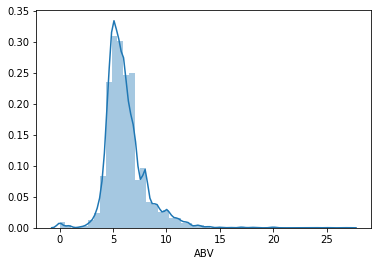

In [1463]:
sns.distplot(df[df.ABV.notnull()]['ABV'])

/home/cx02358/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


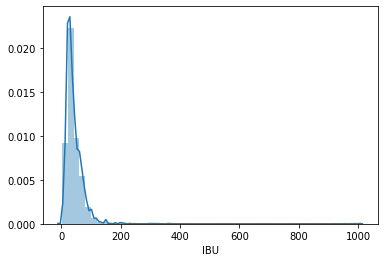

In [1464]:
sns.distplot(df[df.IBU.notnull()]['IBU'])

/home/cx02358/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


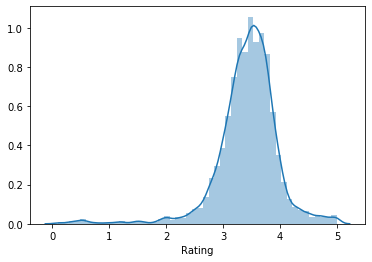

In [1465]:
sns.distplot(df[df.Rating.notnull()]['Rating'])

(0, 200)

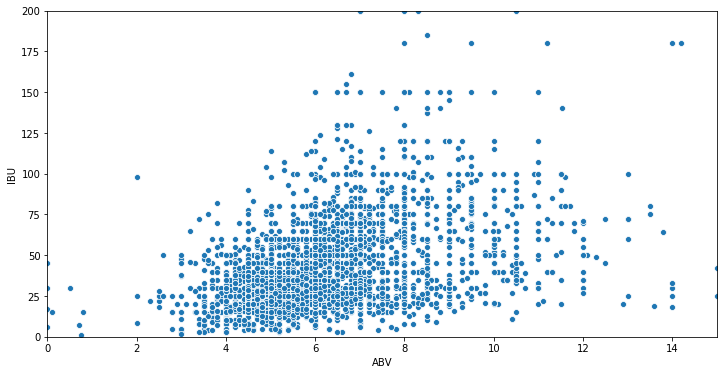

In [1466]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ABV', y='IBU', data=df)
plt.xlim(0, 15)
plt.ylim(0, 200)

# Groupby

In [1467]:
df_grouped = df.groupby('Style').agg({'ABV': ['mean', 'count'],
                                      'IBU': ['mean', 'count'],
                                      'Rating': ['mean', 'count']}).reset_index()

In [1468]:
df_grouped.columns = df_grouped.columns.droplevel(0)
df_grouped.columns = ['Style', 'ABV_mean', 'ABV_count',
                      'IBU_mean', 'IBU_count', 'Rating_mean', 'Rating_count']

In [1469]:
df_grouped.sort_values(by='IBU_mean', ascending=False).head()

,Style,ABV_mean,ABV_count,IBU_mean,IBU_count,Rating_mean,Rating_count
52,Flanders Brown Ale-Oud Bruin,6.133333,6,102.000000,4,3.522000,5
64,Imperial IPA,8.473480,319,100.134842,221,3.852987,231
25,Black IPA,6.774359,78,71.660317,63,3.707174,46
99,Russian Imperial Stout,10.493750,80,67.109615,52,3.881053,57
45,English Barleywine,10.468750,16,65.166667,6,3.660000,11


# Export dataset

In [1470]:
df.to_csv(data_path+"Beer_dataset_v2.csv")

In [1485]:
df.sample(15)

,Name,Style,ABV,IBU,Rating,Description,Brewery_full,Description_full,Description_full_clean,Name_clean
477,Naparbier Hop Daze,New England IPA,6.0,NaN,3.58,"Hop daze\nNEIPA\nHOP DAZE: NEIPA (6%) Mosaico, Idaho 7, Simcoe. Dulce y suave en boca!\n--------\nHOP DAZE: NEIPA (6%) Mosaic, Idaho 7, Simcoe. Sweet fruit burst as well as a kiss of white wine grapes that rest atop a pillowy mouthfeel.\n",Naparbier,"Hop daze\nNEIPA\nHOP DAZE: NEIPA (6%) Mosaico, Idaho 7, Simcoe. Dulce y suave en boca!\n--------\nHOP DAZE: NEIPA (6%) Mosaic, Idaho 7, Simcoe. Sweet fruit burst as well as a kiss of white wine grapes that rest atop a pillowy mouthfeel.","hop daze: neipa (6% hop daze: neipa (6%) mosaic, idaho 7, simcoe. sweet fruit burst as well as a kiss of white wine grapes that rest atop a pillowy mouthfeel.",naparbier hop daze
3902,El Cabo Summer Ale,Blonde Ale,4.3,16.0,2.98,"El Cabo Summer Ale\r\nRefrescante, suave e insaciable. Fugaz e intensa como un amor de verano.\r\nLa cerveza perfecta para los días mas calurosos, tostada, aromática con tonos menta y cítricos.",Cervezas El Cabo,"El Cabo Summer Ale\r\nRefrescante, suave e insaciable. Fugaz e intensa como un amor de verano.\r\nLa cerveza perfecta para los días mas calurosos, tostada, aromática con tonos menta y cítricos.","refrescante, suave e in la cerveza perfecta para los días mas calurosos, tostada, aromática con tonos menta y cítricos.",el cabo summer ale
2103,Santo Cristo Strawberry Sour Forever,Sour Ale,5.4,NaN,NaN,"Strawberry Sour Forever\r\nRaúl\r\nSoured Strawberry Ale\r\nParte de las 4 cervezas del 4niversario. Soured Ale con malta Pilsen, fresa en puré, Sour Pitch de Lallemand y levadura de corte belga, se ha conseguido una cerveza de sólo 3,8%vol, altamente adictiva, aroma y sabor a fresa natural, entra ...",Santo Cristo,"Strawberry Sour Forever\r\nRaúl\r\nSoured Strawberry Ale\r\nParte de las 4 cervezas del 4niversario. Soured Ale con malta Pilsen, fresa en puré, Sour Pitch de Lallemand y levadura de corte belga, se ha conseguido una cerveza de sólo 3,8%vol, altamente ... Ver más aroma y sabor a fresa natural, entrada en boca ácida y final dulce. Ver menos","parte de las 4 cervezas del 4niversario. soured ale con malta pilsen, fresa en puré, sour pitch de lallemand y levadura de corte belga, se ha conseguido una cerveza de sólo 3,8%vol, altamente ... ver más aroma y sabor a fresa natural, entrada en boca ácida y final dulce. ver menos",santo cristo strawberry sour forever
3410,The Rolling Beer EPA,English Pale Ale,5.6,33.0,4.50,The Rolling Beer EPA\r\nEnglish Punk Ale,NaN,,,the rolling beer epa
1370,Yria Brutalism,Brut IPA,7.0,30.0,3.65,Brutalism\nBrut IPA\nBrutalism es una cerveza de color amarillo brillante. En aroma muy presente la fruta y en boca muy compensado el toque amargo de una brut IPA con la frescura y dulzura que posee.\n,Yria,Brutalism\nBrut IPA\nBrutalism es una cerveza de color amarillo brillante. En aroma muy presente la fruta y en boca muy compensado el toque amargo de una brut IPA con la frescura y dulzura que posee.\n,brutalism es una cerveza de color amarillo brillante. en aroma muy presente la fruta y en boca muy compensado el toque amargo de una brut ipa con la frescura y dulzura que posee.,yria brutalism
2580,Killa Blanche Quinoa,"Spice, Herb o Vegetable Beer",4.0,NaN,NaN,"Killa Blanche Quinoa\r\nNutritiva\r\nCerveza artesanal innovadora 100% natural, que aporta a nuestro organismo vitaminas, es nutritiva por contener “Quinoa” originario de Perú, es una cerveza muy aromática de dulzor moderado y cuerpo medio.\r\nSu fermentación en altas temperaturas hace que adq ...",Killa,"Killa Blanche Quinoa\r\nNutritiva\r\nCerveza artesanal innovadora 100% natural, que aporta a nuestro organismo vitaminas, es nutritiva por contener “Quinoa” originario de Perú, es una cerveza muy aromática de dulzor moderado y cuerpo medio.\r\nSu ... Ver más en altas temperaturas hace que adquiera un ligero aroma avainillado, dulce; ligero sabor dulce a granos, quinoa; con gusto 

In [1487]:
df.Name.iloc[0]

# .apply(lambda x: re.sub)

# >>> re.sub(r"(\w)(\w+)(\w)", repl, text)

'La Vella Caravana / Black Bitch Caravan of Bitches'

In [1493]:
def extract_name(df, column_name, column_brewery):
    for i in range(df.shape[0]):
        name = df[column_name].iloc[i]
        brewery = df[column_brewery].iloc[i]
        name = name.replace(brewery, "")
        print(name, brewery)

In [1494]:
extract_name(df.iloc[0:10], 'Name', 'Brewery_full')

La Vella Caravana / Black Bitch Caravan of Bitches La Vella CaravanaBlack Bitch Brewing Co
 Sour Lady BlackLab
Blacklab Claudia Passion BlackLab
 More Sparkle BlackLab
 Give ’em Hops Greyhound Brewers
 Slave of New Hops Greyhound Brewers
 Born Of The Hops Greyhound Brewers
Engorile King Hop Engorile - U-Hops
 Malaspina Brown Ale Castelló Beer Factory
Castelló Beer Factory / Althaia Fifth Element Castelló Beer FactoryAlthaia Artesana


In [1492]:
"hola hello".replace("hello", "hldf")

'hola hldf'